In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from lm_polygraph.ue_metrics.ue_metric import (
    get_random_scores,
    normalize_metric,
)
import sklearn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from sacrebleu import CHRF, BLEU
from utils import extract_and_prepare_data

/opt/homebrew/Caskroom/miniconda/base/envs/ue_abssum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
methods_dict = {
    'MeanTokenEntropy': 'MTE',
}

# DATASETS = [
#     'wmt14_csen',
#     'wmt14_deen',
#     'wmt14_ruen',
#     'wmt14_fren',
#     'wmt19_deen',
#     'wmt19_fien',
#     'wmt19_lten',
#     'wmt19_ruen',
# ]

DATASETS = [
    'wmt14_csen',
    #'wmt14_deen',
    'wmt14_ruen',
    #'wmt14_fren',
    #'wmt19_deen',
    #'wmt19_fien',
    #'wmt19_lten',
    #'wmt19_ruen',
]

all_metrics = ['Comet']

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:705: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
Loading NLI

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x32ddf6680>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x33be92c50>]


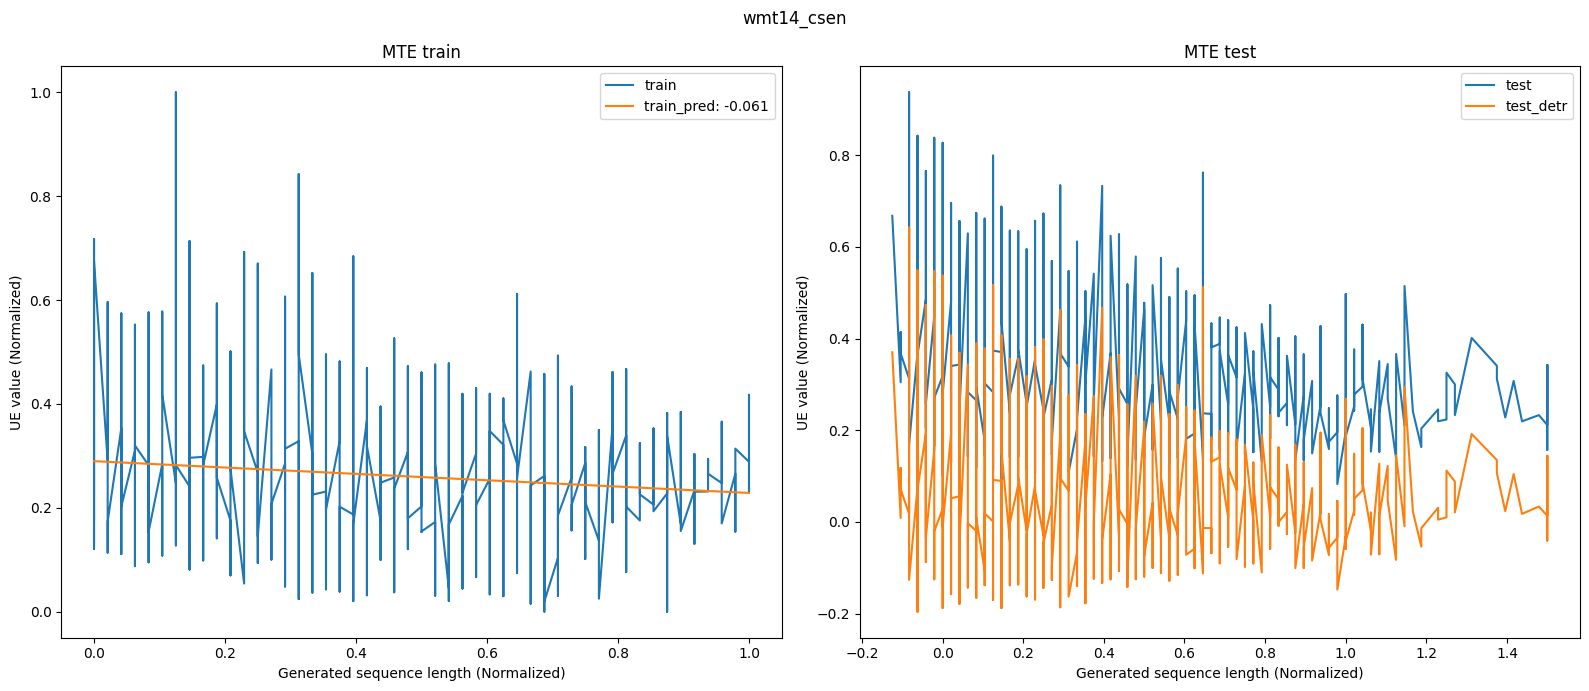

/Users/romanvashurin/workspace/lm-polygraph/src/lm_polygraph/utils/manager.py:705: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)
Loading NLI

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x32dd36f20>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x3ae047040>]


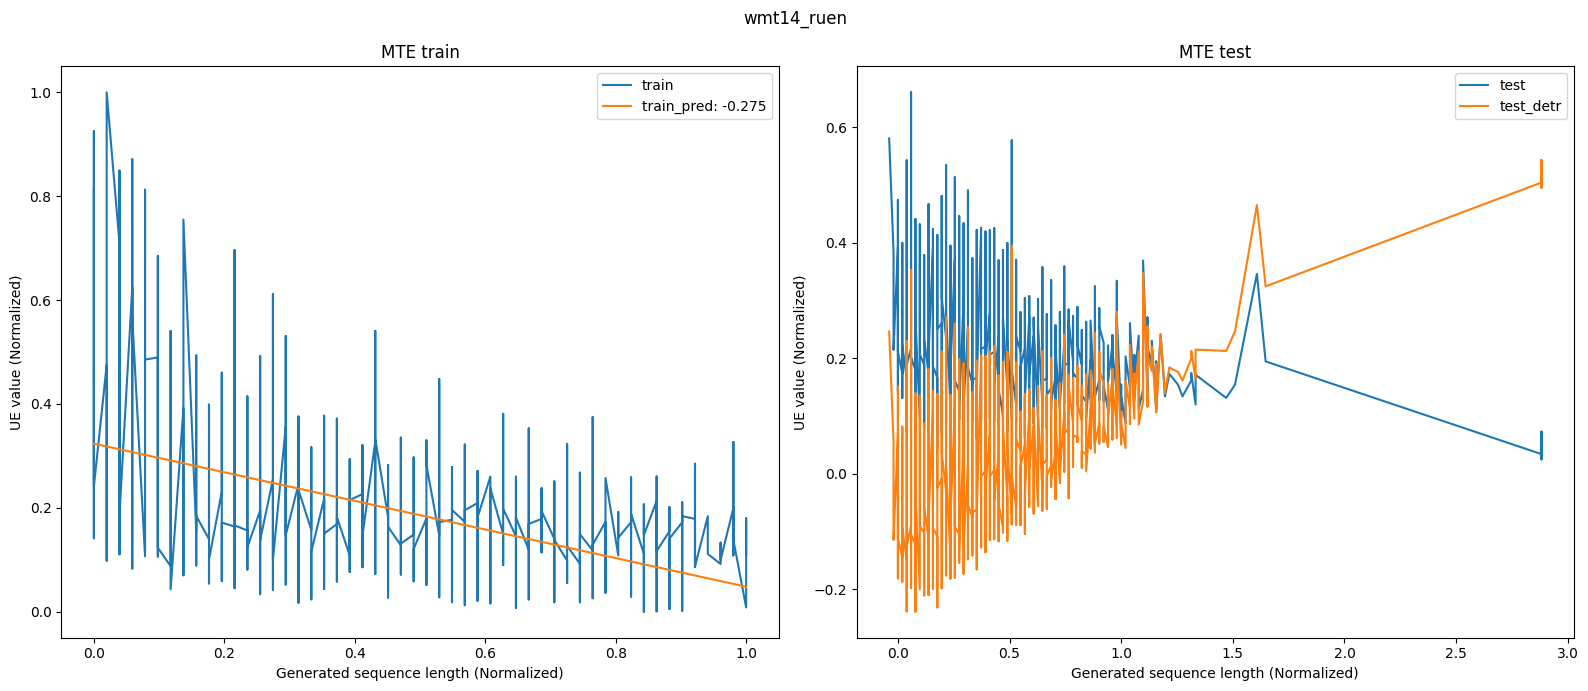

In [3]:
coefs = defaultdict(list)

for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    upper_q = np.quantile(train_gen_lengths, 0.95)
    lower_q = np.quantile(train_gen_lengths, 0.05)
    below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
    train_gen_lengths = train_gen_lengths[below_q_ids]

    fig, axs = plt.subplots(1, 2, figsize=(8 * 2, 7))
    #for i, method in enumerate(ue_methods):
    method = 'MTE'
    gen_length_scaler = MinMaxScaler()
    train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()
    test_gen_lengths_normalized = gen_length_scaler.transform(gen_lengths[:, np.newaxis]).squeeze()

    train_ue = train_ue_values[method][below_q_ids]
    test_ue = test_ue_values[method]
    
    scaler = MinMaxScaler()
    train_normalized_ue = scaler.fit_transform(train_ue[:, np.newaxis]).squeeze()
    test_normalized_ue = scaler.transform(test_ue[:, np.newaxis]).squeeze()
    
    train_linreg = sklearn.linear_model.LinearRegression()
    train_linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_ue)
    coef = train_linreg.coef_[0]

    test_residuals = train_linreg.predict(test_gen_lengths_normalized[:, np.newaxis])
    test_detr_ue = test_normalized_ue - test_residuals
    
    train_sort_order = np.argsort(train_gen_lengths_normalized)
    test_sort_order = np.argsort(test_gen_lengths_normalized)
    
    axs[0].plot(train_gen_lengths_normalized[train_sort_order], train_normalized_ue[train_sort_order], label='train')
    axs[0].plot(train_gen_lengths_normalized[train_sort_order], train_linreg.predict(train_gen_lengths_normalized[train_sort_order][:, np.newaxis]), label=f'train_pred: {round(coef,3)}')
    axs[0].legend()
    axs[0].set_title('MTE train')
    axs[0].set_xlabel('Generated sequence length (Normalized)')
    axs[0].set_ylabel('UE value (Normalized)')

    axs[1].plot(test_gen_lengths_normalized[test_sort_order], test_normalized_ue[test_sort_order], label='test')
    axs[1].plot(test_gen_lengths_normalized[test_sort_order], test_detr_ue[test_sort_order], label='test_detr')
    axs[1].legend()
    axs[1].set_title('MTE test')
    axs[1].set_xlabel('Generated sequence length (Normalized)')
    axs[1].set_ylabel('UE value (Normalized)')

    fig.suptitle(dataset)

    plt.tight_layout()
    plt.show()